<a href="https://colab.research.google.com/github/dyna-bytes/PyTorchIntensive/blob/main/00_Final(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 변수의 shape, type, value 확인
def p(var,_str='') :
    if _str=='\n' or _str=='cr' :
        _str = '\n'
    else :
        print(f'[{_str}]:')
        _str = ''
    if type(var)!=type([]):
        try:
            print(f'Shape:{var.shape}')
        except :
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}'+_str)

def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}')

# 평가 과제 : ResNet 개선 실습

## 과제 1 : Pre Activation Model로 수정하기

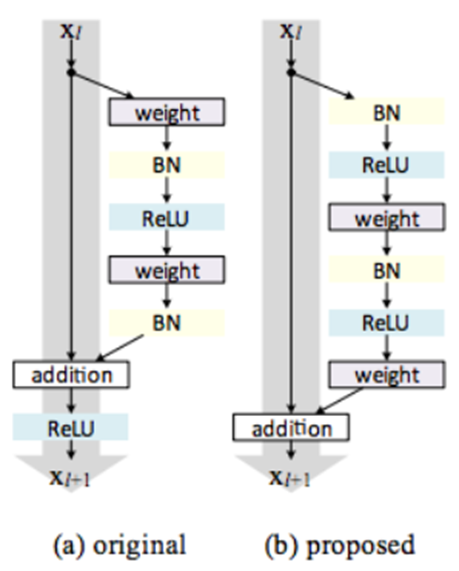

In [ ]:
%%capture
!pip install pytorch_lightning torchinfo torchmetrics torchviz

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics import functional as FM
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import CSVLogger
import numpy as np
import pandas as pd
import os
from PIL import Image
from IPython import display
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3.5]

device ='cuda:0'
torch.__version__

'2.0.1+cu118'

### Post Activation Block ##
```python
class BottleNeck(nn.Module):
    def __init__(self, in_channels, base_channels, stride=1, conv_shortcut=False):
        super().__init__()
        if conv_shortcut: # Conv Block
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, base_channels*4, 1, stride, bias=False),
                nn.BatchNorm2d(base_channels*4)
            )
        else : # Identity Block
            self.shortcut = nn.Sequential()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 1, 1, bias=False),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(),
            nn.Conv2d(base_channels, base_channels, 3, stride, padding=1, bias=False),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(),
            nn.Conv2d(base_channels, base_channels * 4, 1, 1, bias=False),
            nn.BatchNorm2d(base_channels * 4),
        )
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x
```        

### Pre Activation Block 으로 수정

In [ ]:
class BottleNeck(nn.Module):
    def __init__(self, in_channels, base_channels, stride=1, conv_shortcut=False):
        super().__init__()
        if conv_shortcut: # Conv Block
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, base_channels*4, 1, stride, bias=False),
                nn.BatchNorm2d(base_channels*4)
            )
        else : # Identity Block
            self.shortcut = nn.Sequential()
        self.residual_function = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, base_channels, 1, 1, bias=False),

            nn.BatchNorm2d(base_channels),
            nn.ReLU(),
            nn.Conv2d(base_channels, base_channels, 3, stride, padding=1, bias=False),

            nn.Conv2d(base_channels, base_channels * 4, 1, 1, bias=False),
            nn.BatchNorm2d(base_channels * 4),
        )
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [ ]:
# nn.Conv2d(in_c, out_c, kernel_size, stride, padding, bias=True)
# nn.MaxPool2d(kernel_size, stride, padding)

class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=1000, init_weights=True):
        super().__init__()
        self.in_channels=64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 7, 2, 3, bias=False),           #(64,112,112)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1) #(64,56,56)
        )
        ## Stacking Conv Block ##
        self.conv2_x = self._make_blocks(64, 64, num_block[0], 1)
        self.conv3_x = self._make_blocks(256, 128, num_block[1], 2)
        self.conv4_x = self._make_blocks(512, 256, num_block[2], 2)
        self.conv5_x = self._make_blocks(1024, 512, num_block[3], 2)
        ##
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))#out:(1,1)#(2048,1,1)
        self.fc = nn.Linear(512*4, num_classes)              #(1000)

    def _make_blocks(self, in_channels, base_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1) #[1,1,1] or [2,1,1]
        layers = []
        layers.append(BottleNeck(in_channels, base_channels, strides[0],
                                                                   conv_shortcut=True))
        for n_block in range(1, num_blocks):
            layers.append(BottleNeck(base_channels*4, base_channels, strides[n_block]))
        return nn.Sequential(*layers)

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1) ## flatten
        x = self.fc(x)
        return x

In [ ]:
def resnet50():
    return ResNet(BottleNeck,num_block=[3, 4, 6, 3])

def resnet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [ ]:
model = resnet50()
summary(model, input_size=(16, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 1000]                --
├─Sequential: 1-1                        [16, 64, 56, 56]          --
│    └─Conv2d: 2-1                       [16, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                  [16, 64, 112, 112]        128
│    └─ReLU: 2-3                         [16, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                    [16, 64, 56, 56]          --
├─Sequential: 1-2                        [16, 256, 56, 56]         --
│    └─BottleNeck: 2-5                   [16, 256, 56, 56]         --
│    │    └─Sequential: 3-1              [16, 256, 56, 56]         58,112
│    │    └─Sequential: 3-2              [16, 256, 56, 56]         16,896
│    │    └─ReLU: 3-3                    [16, 256, 56, 56]         --
│    └─BottleNeck: 2-6                   [16, 256, 56, 56]         --
│    │    └─Sequential: 3-4              [16, 256, 56, 56]         70,784

## 과제2 : 실습 Custom ResNet 만들기
* ResNet26 Model 만들어 보자  
 - Conv Block 반복 횟수를 어떻게 배분할까?  
* Flower Photos Dataset을 학습시켜 보자  
 - 목표 : 68% 이상

### ResNet26: Cumstom ResNet Model  

In [ ]:
model = ResNet(BottleNeck, [2, 2, 2, 2], num_classes=5)
summary(model, input_size=(16, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 5]                   --
├─Sequential: 1-1                        [16, 64, 56, 56]          --
│    └─Conv2d: 2-1                       [16, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                  [16, 64, 112, 112]        128
│    └─ReLU: 2-3                         [16, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                    [16, 64, 56, 56]          --
├─Sequential: 1-2                        [16, 256, 56, 56]         --
│    └─BottleNeck: 2-5                   [16, 256, 56, 56]         --
│    │    └─Sequential: 3-1              [16, 256, 56, 56]         58,112
│    │    └─Sequential: 3-2              [16, 256, 56, 56]         16,896
│    │    └─ReLU: 3-3                    [16, 256, 56, 56]         --
│    └─BottleNeck: 2-6                   [16, 256, 56, 56]         --
│    │    └─Sequential: 3-4              [16, 256, 56, 56]         70,784

In [ ]:
loss_function = nn.CrossEntropyLoss()

class ResNet26(pl.LightningModule):
    def __init__(self):
        super(ResNet26, self).__init__()
        self.layers = ResNet(BottleNeck, [2, 2, 2, 2], num_classes=5)

    def forward(self, x):
        out = self.layers(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=5)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics,prog_bar=True,on_step=False,on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=5)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics,prog_bar=True,on_step=False,on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

model = ResNet26()
summary(model, input_size=(16, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
ResNet26                                      [16, 5]                   --
├─ResNet: 1-1                                 [16, 5]                   --
│    └─Sequential: 2-1                        [16, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                       [16, 64, 112, 112]        9,408
│    │    └─BatchNorm2d: 3-2                  [16, 64, 112, 112]        128
│    │    └─ReLU: 3-3                         [16, 64, 112, 112]        --
│    │    └─MaxPool2d: 3-4                    [16, 64, 56, 56]          --
│    └─Sequential: 2-2                        [16, 256, 56, 56]         --
│    │    └─BottleNeck: 3-5                   [16, 256, 56, 56]         75,008
│    │    └─BottleNeck: 3-6                   [16, 256, 56, 56]         70,784
│    └─Sequential: 2-3                        [16, 512, 28, 28]         --
│    │    └─BottleNeck: 3-7                   [16, 512, 28, 28]         379,648
│  

### Flower Photos Dataset Load

In [ ]:
from torchvision.datasets.utils import download_and_extract_archive

dataset_url = \
      "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
root = './'
data_dir='Dataset'
download_and_extract_archive(dataset_url, root, data_dir)
data_dir = root+data_dir+'/flower_photos'
data_dir

100%|██████████| 228813984/228813984 [00:01<00:00, 220643354.23it/s]


Extracting ./flower_photos.tgz to Dataset


'./Dataset/flower_photos'

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
import pathlib

sp_path="flower_photos_sp"
splitfolders.ratio(data_dir, output=sp_path,
    seed=1337, ratio=(.7, .3), group_prefix=None, move=True )
sp_train = pathlib.Path(sp_path+'/train')
sp_test = pathlib.Path(sp_path+'/val')
sp_train

Copying files: 3670 files [00:00, 20947.92 files/s]


PosixPath('flower_photos_sp/train')

In [ ]:
# 지정 폴더 아래에 있는 모든 *.jpg 파일의 수
#  및 폴더명 목록을 리턴
def check_dir(d_path):
    img_count = len(list(d_path.glob('*/*.jpg')))
    c_name = np.array([item.name for item in d_path.glob('*') if item.name != "LICENSE.txt"])
    return img_count, c_name, len(c_name)

# check_dir()로 폴더명과 이미지 숫자 확인
image_count, CLASS_train, class_num = check_dir(sp_train)
CLASS_train.sort()
print('Train image_count: {}\nclasses: {}'.format(image_count, CLASS_train))
image_count, CLASS_test, class_num = check_dir(sp_test)
CLASS_test.sort()
print('Test image_count: {}\nclasses: {}'.format(image_count, CLASS_test))

Train image_count: 2567
classes: ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']
Test image_count: 1103
classes: ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


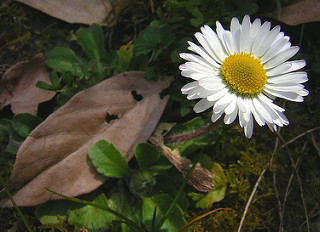

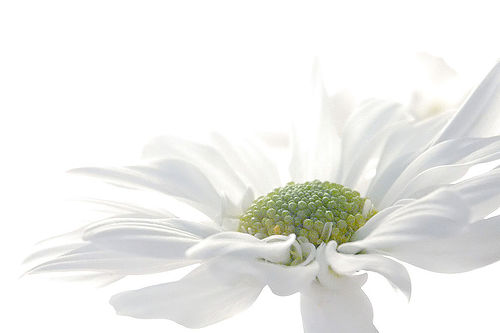

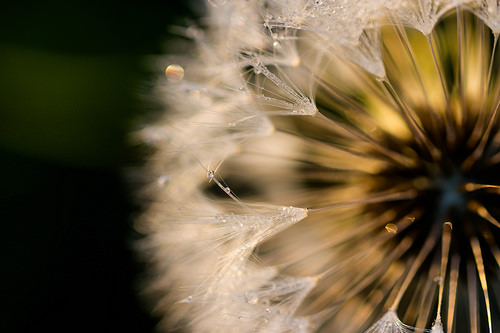

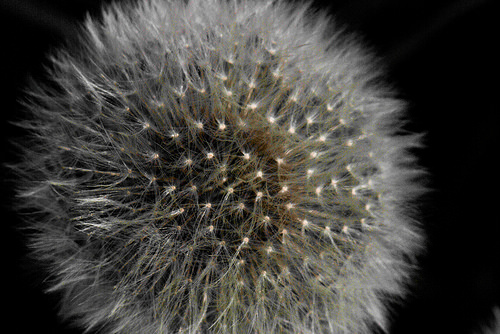

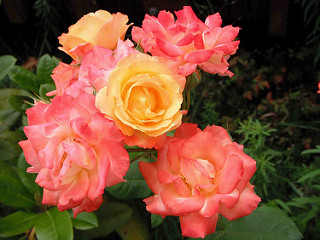

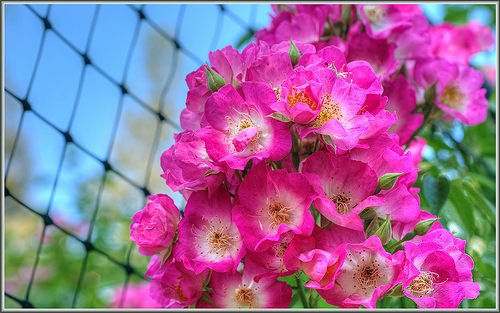

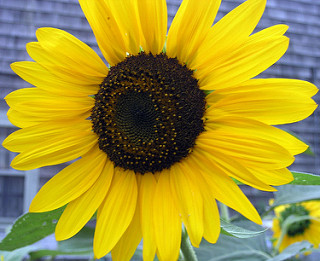

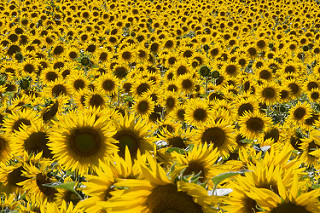

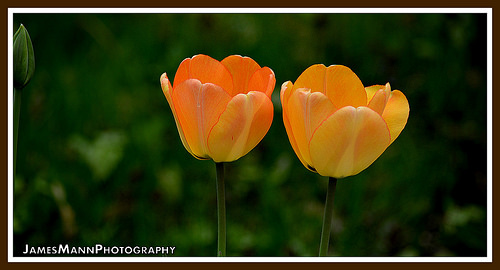

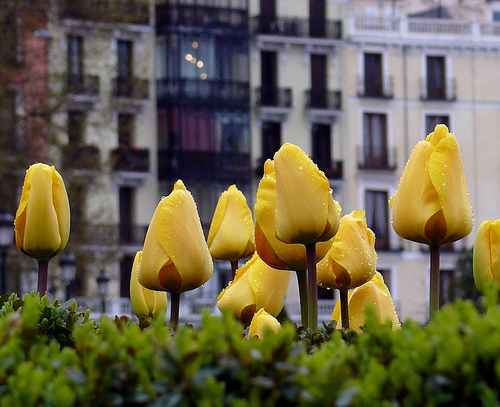

In [ ]:
# 지정 path 아래에 있는 폴더에서 이미지 두장씩을 확인
def check_image(d_path, class_list):
    for i in range(len(class_list)):
        class_temp = list(d_path.glob(str(class_list[i])+'/*'))
        for image_path in class_temp[:2]:
            display.display(Image.open(str(image_path)))
# check_image()로 이미지 두장씩 확인
check_image(sp_train, CLASS_train)

In [ ]:
# Imagae size **
IN_IMG_SIZE = 224
batch_n = 64

In [ ]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

## loader에 적용할 transform
train_transforms = transforms.Compose([transforms.Resize((IN_IMG_SIZE, IN_IMG_SIZE)),
                             transforms.RandomAffine(degrees=40, translate=(0.2, 0.2), shear=0.2),
                             transforms.RandomResizedCrop(IN_IMG_SIZE, scale=[0.8, 1.0]),
                             transforms.RandomHorizontalFlip(0.5),
                              transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize((IN_IMG_SIZE, IN_IMG_SIZE)),
                              transforms.ToTensor()])

## ImageFolder : folder로 구성된 image set을 위한 loader
train_imgs = ImageFolder(sp_train, transform=train_transforms) #(image,label)
test_imgs = ImageFolder(sp_test, transform=test_transforms)

## DataLoader : dataset과 sampler를 결합 batch단위 제공 #(image,label)*batch
train_loader = DataLoader(train_imgs, batch_size=batch_n, shuffle=True, num_workers=4)
test_loader = DataLoader(test_imgs, batch_size=batch_n, shuffle=False, num_workers=4)

len(train_imgs),len(test_imgs)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(2567, 1103)

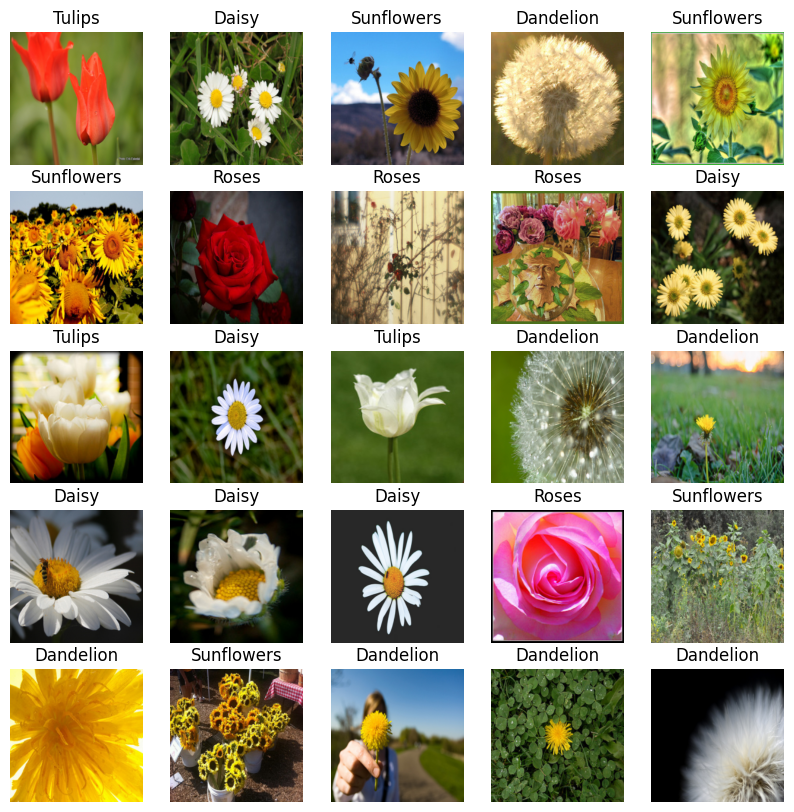

In [ ]:
def show_batch(data_gen, class_l):
    # get image and label from data generator
    img_batch, l_batch = next(iter(data_gen))
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(img_batch[n].permute(1, 2, 0))
        plt.title(class_l[l_batch[n]].title())
        plt.axis('off')
    return img_batch, l_batch

# check dataset
_,_ = show_batch(train_loader, CLASS_train)

### Training

In [ ]:
%%time
model = ResNet26()

epochs=15
logger = CSVLogger("logs", name="ResNet")
trainer = Trainer(max_epochs=epochs, logger=logger, accelerator='auto',
                  limit_train_batches=0.5, limit_val_batches=0.5)
trainer.fit(model, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type   | Params
----------------------------------
0 | layers | ResNet | 14.0 M
----------------------------------
14.0 M    Trainable params
0         Non-trainable params
14.0 M    Total params
55.856    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


CPU times: user 1min 10s, sys: 11.9 s, total: 1min 22s
Wall time: 4min 24s


#### Analysis

In [ ]:
v_num = logger.version
history1 = pd.read_csv(f'./logs/ResNet/version_{v_num}/metrics.csv')
history1_plot = history1.drop('step', axis=1).groupby('epoch').last()

	 0.7430555820465088


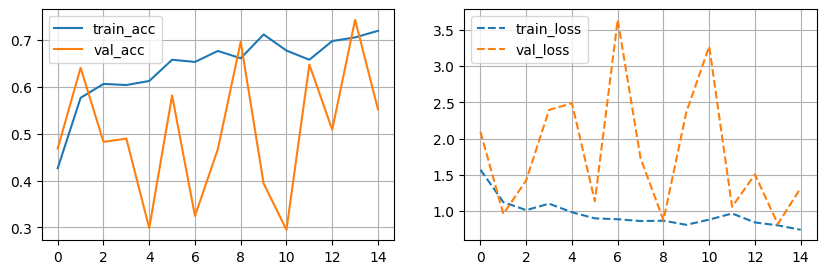

In [ ]:
import matplotlib.pylab as plt
print('\t',np.max(history1_plot['val_acc']))

fig = plt.figure(figsize = (10, 3))
plt.subplot(121)
plt.plot(history1_plot['acc'], linestyle='-', label="train_acc")
plt.plot(history1_plot['val_acc'], linestyle='-', label="val_acc")
#plt.ylim(0.1, 1)
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(history1_plot['loss'], linestyle='--', label="train_loss")
plt.plot(history1_plot['val_loss'], linestyle='--', label="val_loss")
#plt.ylim(0.1, 1)
plt.legend()
plt.grid()
plt.show()

## 과제3 : Exponential decay scheduler Tuning 하기  
 목표 : val_acc 75%이상   
* starter_learning_rate = 0.001  
* decay_steps = ?  
* decay_rate= ?   

In [ ]:
epochs=15
lr_start = 0.002

In [ ]:
decay_steps = epochs//3
decay_rate=0.6
def exponential_decay_lambda(epoch):
    return decay_rate ** (epoch // decay_steps)

def manual_decay_lambda(epoch):
    if epoch/epochs > .75 : return 0.1
    if epoch/epochs > .5 : return 0.5
    return 1

inverse_time_decay_lambda = lambda epoch: 1 / (1 +
              decay_rate * epoch / decay_steps)

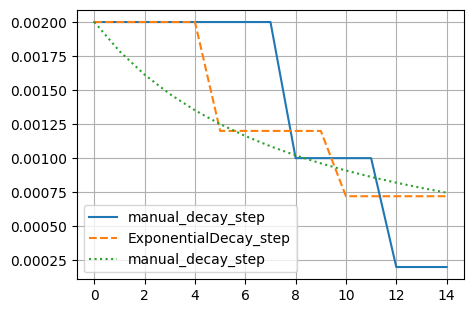

In [ ]:
man_lr_s=[]
exp_lr_s=[]
inv_lr_s=[]

for step in range(epochs):
    man_lr_s.append(manual_decay_lambda(step)*lr_start)
    exp_lr_s.append(exponential_decay_lambda(step)*lr_start)
    inv_lr_s.append(inverse_time_decay_lambda(step)*lr_start)

plt.plot(man_lr_s, linestyle='-', label="manual_decay_step")
plt.plot(exp_lr_s, linestyle='--', label="ExponentialDecay_step")
plt.plot(inv_lr_s, linestyle=':', label="manual_decay_step")
plt.legend()
plt.grid()
plt.show()

- define lr scheduling

### 과제 3-1

In [ ]:
loss_function = nn.CrossEntropyLoss()
class ResNet26(pl.LightningModule):
    def __init__(self):
      super(ResNet26, self).__init__()
      self.layers = ResNet(BottleNeck, [2, 2, 2, 2], num_classes=5)

    def forward(self, x):
        out = self.layers(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=5)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics,prog_bar=True,on_step=False,on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=5)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics,prog_bar=True,on_step=False,on_epoch=True)

    def configure_optimizers(self):
        optimizer =  torch.optim.Adam(self.parameters(), lr=lr_start)
        lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = inverse_time_decay_lambda)
        return [optimizer], [lr_scheduler]

In [ ]:
%%time
model = ResNet26()

epochs=15
logger = CSVLogger("logs", name="ResNet")
trainer = Trainer(max_epochs=epochs, logger=logger, accelerator='auto',
                  limit_train_batches=0.5, limit_val_batches=0.5)
trainer.fit(model, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type   | Params
----------------------------------
0 | layers | ResNet | 14.0 M
----------------------------------
14.0 M    Trainable params
0         Non-trainable params
14.0 M    Total params
55.856    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


CPU times: user 1min, sys: 14.3 s, total: 1min 14s
Wall time: 4min 24s


#### Analysis

In [ ]:
v_num = logger.version
history1 = pd.read_csv(f'./logs/ResNet/version_{v_num}/metrics.csv')
history1_plot = history1.drop('step', axis=1).groupby('epoch').last()

	 0.7170138955116272


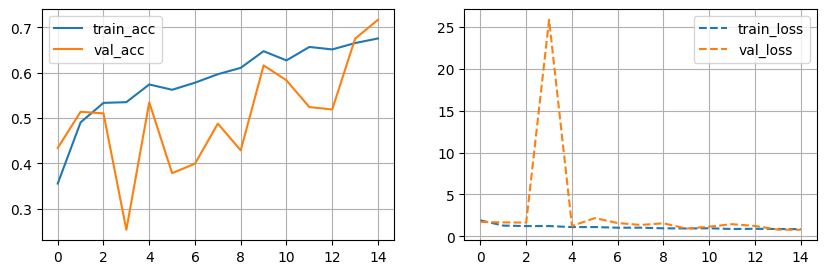

In [ ]:
import matplotlib.pylab as plt
print('\t',np.max(history1_plot['val_acc']))

fig = plt.figure(figsize = (10, 3))
plt.subplot(121)
plt.plot(history1_plot['acc'], linestyle='-', label="train_acc")
plt.plot(history1_plot['val_acc'], linestyle='-', label="val_acc")
#plt.ylim(0.1, 1)
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(history1_plot['loss'], linestyle='--', label="train_loss")
plt.plot(history1_plot['val_loss'], linestyle='--', label="val_loss")
#plt.ylim(0.1, 1)
plt.legend()
plt.grid()
plt.show()

### 과제 3-2

In [ ]:
lr_start = 0.0015

loss_function = nn.CrossEntropyLoss()
class ResNet26(pl.LightningModule):
    def __init__(self):
      super(ResNet26, self).__init__()
      self.layers = ResNet(BottleNeck, [2, 2, 2, 2], num_classes=5)

    def forward(self, x):
        out = self.layers(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=5)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics,prog_bar=True,on_step=False,on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=5)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics,prog_bar=True,on_step=False,on_epoch=True)

    def configure_optimizers(self):
        optimizer =  torch.optim.Adam(self.parameters(), lr=lr_start)
        lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = inverse_time_decay_lambda)
        return [optimizer], [lr_scheduler]

In [ ]:
%%time
model = ResNet26()

epochs=15
logger = CSVLogger("logs", name="ResNet")
trainer = Trainer(max_epochs=epochs, logger=logger, accelerator='auto',
                  limit_train_batches=0.5, limit_val_batches=0.5)
trainer.fit(model, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type   | Params
----------------------------------
0 | layers | ResNet | 14.0 M
----------------------------------
14.0 M    Trainable params
0         Non-trainable params
14.0 M    Total params
55.856    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


CPU times: user 59.8 s, sys: 13.9 s, total: 1min 13s
Wall time: 4min 22s


#### Analysis

In [ ]:
v_num = logger.version
history1 = pd.read_csv(f'./logs/ResNet/version_{v_num}/metrics.csv')
history1_plot = history1.drop('step', axis=1).groupby('epoch').last()

	 0.7847222089767456


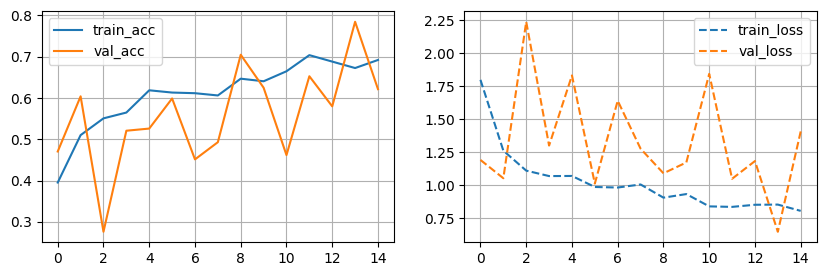

In [ ]:
import matplotlib.pylab as plt
print('\t',np.max(history1_plot['val_acc']))

fig = plt.figure(figsize = (10, 3))
plt.subplot(121)
plt.plot(history1_plot['acc'], linestyle='-', label="train_acc")
plt.plot(history1_plot['val_acc'], linestyle='-', label="val_acc")
#plt.ylim(0.1, 1)
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(history1_plot['loss'], linestyle='--', label="train_loss")
plt.plot(history1_plot['val_loss'], linestyle='--', label="val_loss")
#plt.ylim(0.1, 1)
plt.legend()
plt.grid()
plt.show()